## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../albatross_49_6D/outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
### stack albatross outputs
output_dir = '../albatross_49_6D/outputs'
# embeddings = []
# for i in range(10):
#     tmp = np.load(os.path.join(output_dir, f'membatross_embeddings_49_4D_{i}.npy'))
#     embeddings.append(tmp)
# embeddings = np.dstack(embeddings)
# np.save(os.path.join(output_dir, 'membatross_embeddings_49_4D.npy'), embeddings)

In [8]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(output_dir, 'membatross_embeddings_49_6D.npy'))
feature_embeddings.shape

(49, 6, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [9]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 6)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [10]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[-10.35020575,  -3.65412973,  24.70662369,   9.84570986,
          1.38078412,  -5.69718981],
       [-35.40521668,  26.03455215,  38.11523175,   1.26343071,
         -8.67890508, -24.23849612],
       [-30.85921189,  13.51994215,  36.35569899,   9.69122291,
        -14.90290815, -11.63915429],
       ...,
       [-18.51947097,   2.20877618,  33.50401791,   5.33811286,
         -5.27075634, -10.35229997],
       [  2.28957174,   7.05771371,  16.37128496,  12.12084463,
        -14.0192737 , -11.6690915 ],
       [-20.05537082,  11.55399871,   5.3872141 ,   3.87348893,
         17.06444198, -17.95865929]])

In [11]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [12]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [13]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,cr,bigcat,cat_name
0,0,-5.080036,-6.391221,15.234502,9.367058,6.121042,-7.073794,0.779739,1,animal
1,1,-21.259470,21.867940,30.862103,1.512187,-4.570305,-17.661436,0.798485,13,home decor
2,2,-18.352078,22.976653,31.654628,3.747176,-6.312809,-16.025168,0.752845,18,musical instrument
4,4,-8.948049,27.547543,21.136601,9.687062,-2.637284,-19.502388,0.794466,9,electronic device
5,5,-8.524178,29.746550,26.036156,2.987851,-5.516508,-23.897498,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...
1847,1847,-6.584749,9.213790,24.856887,-11.098280,-0.595183,-12.251470,0.803129,24,toy
1848,1848,-12.989706,7.099608,8.954027,-11.692797,2.885648,-20.966065,0.765881,10,food
1850,1850,-14.152420,5.273334,9.918389,-9.641082,3.733511,-19.686046,0.843158,10,food
1851,1851,-6.308407,3.807398,23.838372,8.392934,2.974666,-13.339953,0.800163,1,animal


<IPython.core.display.Javascript object>


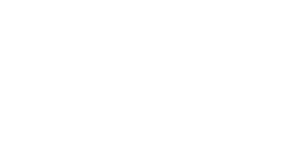

In [14]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], mean_concept_in_feat_cat_na[3]) 

ax.scatter(mean_feature_embed.T[1], mean_feature_embed.T[2], mean_feature_embed.T[3], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [15]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2,3,4,5]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     72.26
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.25e-81
Time:                        13:26:29   Log-Likelihood:                -2435.3
No. Observations:                1854   AIC:                             4885.
Df Residuals:                    1847   BIC:                             4923.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0440      0.003     12.813      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.190102
rsquared_adj,0.187472
coef,"[0.04399716250374286, -0.02264248007293025, -0..."
pvalues,"[4.553786914150021e-36, 2.3086617064353686e-08..."
AIC,4884.512715
BIC,4923.18842
F-statistic,72.255906
F-stats-prob,0.0
Log-Likelihood,-2435.256357


#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [17]:
### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2,3]].values).T
# plt.hist2d(theta, rho,
#            bins = 20)

In [18]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091

# zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


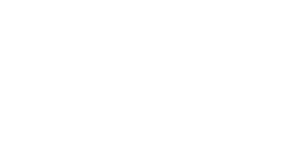

(array([ 91., 219., 271., 349., 366., 305., 153.,  73.,  23.,   4.]),
 array([19.68188948, 23.76216787, 27.84244626, 31.92272465, 36.00300304,
        40.08328143, 44.16355982, 48.24383821, 52.32411659, 56.40439498,
        60.48467337]),
 <BarContainer object of 10 artists>)

In [19]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2,3,4,5]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [20]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.610
Date:                Thu, 06 Oct 2022   Prob (F-statistic):            0.00196
Time:                        13:26:29   Log-Likelihood:                -2625.9
No. Observations:                1854   AIC:                             5256.
Df Residuals:                    1852   BIC:                             5267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0096      0.003     -3.100      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results

,cart_coord_mem,radius_mem
rsquared,0.190102,0.005162
rsquared_adj,0.187472,0.004625
coef,"[0.04399716250374286, -0.02264248007293025, -0...","[-0.00964738961353448, 0.3465832450110044]"
pvalues,"[4.553786914150021e-36, 2.3086617064353686e-08...","[0.0019638731540871767, 0.002434609622985094]"
AIC,4884.512715,5255.828144
BIC,4923.18842,5266.878345
F-statistic,72.255906,9.610435
F-stats-prob,0.0,0.001964
Log-Likelihood,-2435.256357,-2625.914072


#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

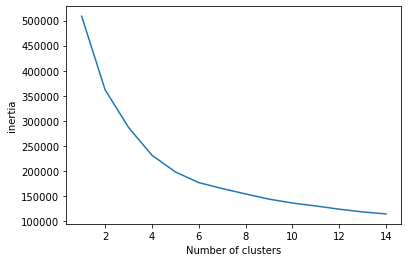

In [22]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4,5]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [23]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4,5]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-1.40654566e+01,  8.31636152e+00,  9.38761329e+00,
        -7.43965835e+00,  3.71680966e+00, -1.82013553e+01],
       [-1.30901680e+01,  1.88047554e+01,  2.41455652e+01,
         5.66975845e-01,  1.54343809e-01, -1.39879300e+01],
       [-7.44500625e+00,  4.58102313e+00,  1.90836279e+01,
         7.06560083e+00,  7.04396521e+00, -1.01493523e+01],
       [ 9.91460967e-03,  2.14429102e+01,  2.61198161e+01,
        -2.74014772e+00, -3.98229846e+00, -2.26287738e+01]])

In [24]:
# ### clusters by memorability and plot concept coordinates in feature space
# %matplotlib notebook


# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [25]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     9.557
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.20e-09
Time:                        13:26:32   Log-Likelihood:                -422.90
No. Observations:                 317   AIC:                             859.8
Df Residuals:                     310   BIC:                             886.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0731      0.023     -3.160      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2,3,4,5]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     7.060
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.65e-07
Time:                        13:26:32   Log-Likelihood:                -429.50
No. Observations:                 317   AIC:                             873.0
Df Residuals:                     310   BIC:                             899.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0896      0.026      3.470      0.0

In [27]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6344
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.426
Time:                        13:26:32   Log-Likelihood:                -449.48
No. Observations:                 317   AIC:                             903.0
Df Residuals:                     315   BIC:                             910.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0126      0.016      0.796      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     11.41
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.66e-12
Time:                        13:26:32   Log-Likelihood:                -1185.7
No. Observations:                 859   AIC:                             2385.
Df Residuals:                     852   BIC:                             2419.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0229      0.010      2.406      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2,3,4,5]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     12.08
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.69e-13
Time:                        13:26:32   Log-Likelihood:                -1183.8
No. Observations:                 859   AIC:                             2382.
Df Residuals:                     852   BIC:                             2415.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0068      0.007     -0.984      0.3

In [30]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2124
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.645
Time:                        13:26:32   Log-Likelihood:                -1218.8
No. Observations:                 859   AIC:                             2442.
Df Residuals:                     857   BIC:                             2451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0030      0.007     -0.461      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     14.98
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.46e-14
Time:                        13:26:32   Log-Likelihood:                -280.42
No. Observations:                 225   AIC:                             574.8
Df Residuals:                     218   BIC:                             598.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0612      0.022      2.816      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2,3,4,5]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     14.03
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.74e-13
Time:                        13:26:32   Log-Likelihood:                -282.53
No. Observations:                 225   AIC:                             579.1
Df Residuals:                     218   BIC:                             603.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0265      0.018      1.457      0.1

In [33]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8595
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.355
Time:                        13:26:32   Log-Likelihood:                -318.83
No. Observations:                 225   AIC:                             641.7
Df Residuals:                     223   BIC:                             648.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0137      0.015     -0.927      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     38.35
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.51e-37
Time:                        13:26:32   Log-Likelihood:                -548.55
No. Observations:                 453   AIC:                             1111.
Df Residuals:                     446   BIC:                             1140.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0877      0.007     12.183      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [35]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2,3,4,5]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     38.28
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.75e-37
Time:                        13:26:32   Log-Likelihood:                -548.69
No. Observations:                 453   AIC:                             1111.
Df Residuals:                     446   BIC:                             1140.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0021      0.007     -0.306      0.7

In [36]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     21.91
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           3.79e-06
Time:                        13:26:32   Log-Likelihood:                -632.04
No. Observations:                 453   AIC:                             1268.
Df Residuals:                     451   BIC:                             1276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0356      0.008     -4.680      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [37]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


In [38]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.17975738973268252

In [39]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.1737283900881017

In [40]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.012242818927676202

### Analysis: coordinates, typicality, memorability


In [41]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [42]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,cr,bigcat,cat_name,typicality
0,0,-5.080036,-6.391221,15.234502,9.367058,6.121042,-7.073794,0.779739,1,animal,0.810913
1,1,-21.259470,21.867940,30.862103,1.512187,-4.570305,-17.661436,0.798485,13,home decor,0.247628
2,2,-18.352078,22.976653,31.654628,3.747176,-6.312809,-16.025168,0.752845,18,musical instrument,0.624589
4,4,-8.948049,27.547543,21.136601,9.687062,-2.637284,-19.502388,0.794466,9,electronic device,0.522380
5,5,-8.524178,29.746550,26.036156,2.987851,-5.516508,-23.897498,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-6.584749,9.213790,24.856887,-11.098280,-0.595183,-12.251470,0.803129,24,toy,0.246697
1848,1848,-12.989706,7.099608,8.954027,-11.692797,2.885648,-20.966065,0.765881,10,food,0.786900
1850,1850,-14.152420,5.273334,9.918389,-9.641082,3.733511,-19.686046,0.843158,10,food,0.770485
1851,1851,-6.308407,3.807398,23.838372,8.392934,2.974666,-13.339953,0.800163,1,animal,0.764335


In [43]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2,3,4,5]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     285.5
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          3.52e-234
Time:                        13:26:32   Log-Likelihood:                -1327.1
No. Observations:                1324   AIC:                             2668.
Df Residuals:                    1317   BIC:                             2704.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0156      0.003      5.416      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
### Polar coordinates vs. typicality
polar_coord = pd.DataFrame(cart_to_polar(grouped[[0,1,2,3,4,5]].values))

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(polar_coord.values, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     213.6
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          2.23e-190
Time:                        13:26:32   Log-Likelihood:                -1428.7
No. Observations:                1324   AIC:                             2871.
Df Residuals:                    1317   BIC:                             2908.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0696      0.004    -17.537      0.0

In [45]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     981.0
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          1.53e-161
Time:                        13:26:32   Log-Likelihood:                -1511.2
No. Observations:                1324   AIC:                             3026.
Df Residuals:                    1322   BIC:                             3037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0899      0.003    -31.321      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.50e-11
Time:                        13:26:32   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

In [47]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,3,4,5,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     52.62
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.29e-66
Time:                        13:26:32   Log-Likelihood:                -1715.3
No. Observations:                1324   AIC:                             3447.
Df Residuals:                    1316   BIC:                             3488.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0420      0.004     10.741      0.0

In [48]:
### Polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(grouped['cr'])
# mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [49]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     22.43
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.64e-10
Time:                        13:26:32   Log-Likelihood:                -1856.6
No. Observations:                1324   AIC:                             3719.
Df Residuals:                    1321   BIC:                             3735.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0860      0.190      5.705      0.0

#### Cluster level typicality

In [50]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [51]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,cr,bigcat,cat_name,label,typicality
0,0,-5.080036,-6.391221,15.234502,9.367058,6.121042,-7.073794,0.779739,1,animal,2,0.810913
1,1,-21.259470,21.867940,30.862103,1.512187,-4.570305,-17.661436,0.798485,13,home decor,1,0.247628
2,2,-18.352078,22.976653,31.654628,3.747176,-6.312809,-16.025168,0.752845,18,musical instrument,1,0.624589
3,4,-8.948049,27.547543,21.136601,9.687062,-2.637284,-19.502388,0.794466,9,electronic device,1,0.522380
4,5,-8.524178,29.746550,26.036156,2.987851,-5.516508,-23.897498,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-6.584749,9.213790,24.856887,-11.098280,-0.595183,-12.251470,0.803129,24,toy,1,0.246697
1320,1848,-12.989706,7.099608,8.954027,-11.692797,2.885648,-20.966065,0.765881,10,food,0,0.786900
1321,1850,-14.152420,5.273334,9.918389,-9.641082,3.733511,-19.686046,0.843158,10,food,0,0.770485
1322,1851,-6.308407,3.807398,23.838372,8.392934,2.974666,-13.339953,0.800163,1,animal,2,0.764335


In [52]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     6.488
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           3.94e-07
Time:                        13:26:32   Log-Likelihood:                -412.49
No. Observations:                 306   AIC:                             841.0
Df Residuals:                     298   BIC:                             870.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0642      0.025     -2.602      0.0

In [53]:
### cluster 0: polar coordinates and typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4,5]] = cart_to_polar(cluster_0[[0,1,2,3,4,5]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.935
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.70e-05
Time:                        13:26:32   Log-Likelihood:                -417.41
No. Observations:                 306   AIC:                             850.8
Df Residuals:                     298   BIC:                             880.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0762      0.027      2.787      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:5]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     5.824
Date:                Thu, 06 Oct 2022   Prob (F-statistic):            0.00330
Time:                        13:26:32   Log-Likelihood:                -428.42
No. Observations:                 306   AIC:                             862.8
Df Residuals:                     303   BIC:                             874.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0335      0.017      2.017      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     7.486
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.34e-08
Time:                        13:26:32   Log-Likelihood:                -721.02
No. Observations:                 526   AIC:                             1458.
Df Residuals:                     518   BIC:                             1492.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0158      0.012      1.332      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
### cluster 1: polar coordinates and typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4,5]] = cart_to_polar(cluster_1[[0,1,2,3,4,5]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     8.182
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.80e-09
Time:                        13:26:32   Log-Likelihood:                -718.78
No. Observations:                 526   AIC:                             1454.
Df Residuals:                     518   BIC:                             1488.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0146      0.009     -1.555      0.1

In [57]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:5]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.771
Date:                Thu, 06 Oct 2022   Prob (F-statistic):            0.00884
Time:                        13:26:32   Log-Likelihood:                -741.61
No. Observations:                 526   AIC:                             1489.
Df Residuals:                     523   BIC:                             1502.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0243      0.009     -2.654      0.0

In [58]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     12.89
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.23e-13
Time:                        13:26:32   Log-Likelihood:                -255.01
No. Observations:                 207   AIC:                             526.0
Df Residuals:                     199   BIC:                             552.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0547      0.025      2.189      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4,5]] = cart_to_polar(cluster_2[[0,1,2,3,4,5]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     12.53
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.80e-13
Time:                        13:26:32   Log-Likelihood:                -255.92
No. Observations:                 207   AIC:                             527.8
Df Residuals:                     199   BIC:                             554.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0457      0.020      2.311      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:5]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     11.77
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.46e-05
Time:                        13:26:32   Log-Likelihood:                -282.42
No. Observations:                 207   AIC:                             570.8
Df Residuals:                     204   BIC:                             580.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0151      0.016      0.964      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     21.24
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           7.40e-23
Time:                        13:26:32   Log-Likelihood:                -343.16
No. Observations:                 285   AIC:                             702.3
Df Residuals:                     277   BIC:                             731.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0732      0.010      7.521      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4,5]] = cart_to_polar(cluster_3[[0,1,2,3,4,5]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     21.13
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           9.58e-23
Time:                        13:26:32   Log-Likelihood:                -343.43
No. Observations:                 285   AIC:                             702.9
Df Residuals:                     277   BIC:                             732.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0090      0.010      0.917      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:5]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     22.57
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           8.11e-10
Time:                        13:26:32   Log-Likelihood:                -383.24
No. Observations:                 285   AIC:                             772.5
Df Residuals:                     282   BIC:                             783.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0161      0.010     -1.563      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [64]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# # ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# # ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# # ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# # ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [65]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.19104594494227944

In [66]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.18632424615331333

In [67]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.06154127424032119

In [68]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [69]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     41.66
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.85e-18
Time:                        13:26:32   Log-Likelihood:                -1838.2
No. Observations:                1324   AIC:                             3682.
Df Residuals:                    1321   BIC:                             3698.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1629      0.026      6.194      0.0

## Categories

In [70]:
# ### color by categories: repeat color assignment
# import matplotlib.colors as mcolors
# %matplotlib notebook

# colors = mcolors.CSS4_COLORS
# by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
#                 for name, color in colors.items())
# color_names = [name for hsv, name in by_hsv]

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
# i = 3
# for name, group in groups:
#     ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
#     i = i+6
# plt.legend(bbox_to_anchor=(0.13,0.7))

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [71]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,cr,bigcat,cat_name,label,typicality
0,0,-5.080036,-6.391221,15.234502,9.367058,6.121042,-7.073794,0.779739,1,animal,2,0.668552
1,1,-21.259470,21.867940,30.862103,1.512187,-4.570305,-17.661436,0.798485,13,home decor,1,0.244049
2,2,-18.352078,22.976653,31.654628,3.747176,-6.312809,-16.025168,0.752845,18,musical instrument,1,0.201728
3,4,-8.948049,27.547543,21.136601,9.687062,-2.637284,-19.502388,0.794466,9,electronic device,1,0.179528
4,5,-8.524178,29.746550,26.036156,2.987851,-5.516508,-23.897498,0.806000,12,furniture,3,0.180429
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-6.584749,9.213790,24.856887,-11.098280,-0.595183,-12.251470,0.803129,24,toy,1,0.068454
1320,1848,-12.989706,7.099608,8.954027,-11.692797,2.885648,-20.966065,0.765881,10,food,0,0.782612
1321,1850,-14.152420,5.273334,9.918389,-9.641082,3.733511,-19.686046,0.843158,10,food,0,0.751898
1322,1851,-6.308407,3.807398,23.838372,8.392934,2.974666,-13.339953,0.800163,1,animal,2,0.629483


In [72]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3,4,5]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     562.5
Date:                Thu, 06 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:26:32   Log-Likelihood:                -1037.6
No. Observations:                1324   AIC:                             2089.
Df Residuals:                    1317   BIC:                             2126.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0071      0.002     -3.072      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     62.33
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.58e-77
Time:                        13:26:32   Log-Likelihood:                -1689.1
No. Observations:                1324   AIC:                             3394.
Df Residuals:                    1316   BIC:                             3436.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0466      0.004     12.257      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [74]:
# ### overall polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(clusters['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [75]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     890.1
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          5.68e-150
Time:                        13:26:32   Log-Likelihood:                -1537.9
No. Observations:                1324   AIC:                             3080.
Df Residuals:                    1322   BIC:                             3090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0873      0.003    -29.835      0.0

In [76]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4,5]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     64.07
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.78e-27
Time:                        13:26:32   Log-Likelihood:                -1817.4
No. Observations:                1324   AIC:                             3641.
Df Residuals:                    1321   BIC:                             3656.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0188      0.005      4.012      0.0

In [77]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     8.300
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.93e-09
Time:                        13:26:32   Log-Likelihood:                -406.94
No. Observations:                 306   AIC:                             829.9
Df Residuals:                     298   BIC:                             859.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0367      0.038      0.962      0.3

In [78]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4,5]] = cart_to_polar(cluster_0[[0,1,2,3,4,5]].values) - cart_to_polar(clusters[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     7.512
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.45e-08
Time:                        13:26:32   Log-Likelihood:                -409.33
No. Observations:                 306   AIC:                             834.7
Df Residuals:                     298   BIC:                             864.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0067      0.034     -0.201      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:5]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     16.52
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.55e-07
Time:                        13:26:32   Log-Likelihood:                -418.36
No. Observations:                 306   AIC:                             842.7
Df Residuals:                     303   BIC:                             853.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0470      0.016      2.891      0.0

In [80]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     8.457
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           8.16e-10
Time:                        13:26:32   Log-Likelihood:                -717.90
No. Observations:                 526   AIC:                             1452.
Df Residuals:                     518   BIC:                             1486.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0109      0.012      0.914      0.3

In [81]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4,5]] = cart_to_polar(cluster_1[[0,1,2,3,4,5]].values) - cart_to_polar(clusters[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     9.448
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.69e-11
Time:                        13:26:32   Log-Likelihood:                -714.76
No. Observations:                 526   AIC:                             1446.
Df Residuals:                     518   BIC:                             1480.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0192      0.009     -2.085      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:5]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.150
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.117
Time:                        13:26:32   Log-Likelihood:                -744.21
No. Observations:                 526   AIC:                             1494.
Df Residuals:                     523   BIC:                             1507.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0184      0.009     -2.066      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     13.48
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           3.29e-14
Time:                        13:26:32   Log-Likelihood:                -253.56
No. Observations:                 207   AIC:                             523.1
Df Residuals:                     199   BIC:                             549.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0817      0.025      3.245      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [84]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4,5]] = cart_to_polar(cluster_2[[0,1,2,3,4,5]].values) - cart_to_polar(clusters[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     11.83
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.43e-12
Time:                        13:26:32   Log-Likelihood:                -257.71
No. Observations:                 207   AIC:                             531.4
Df Residuals:                     199   BIC:                             558.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0352      0.020      1.738      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:5]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     26.70
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.00e-11
Time:                        13:26:32   Log-Likelihood:                -269.65
No. Observations:                 207   AIC:                             545.3
Df Residuals:                     204   BIC:                             555.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0068      0.014     -0.504      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     20.81
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.94e-22
Time:                        13:26:32   Log-Likelihood:                -344.18
No. Observations:                 285   AIC:                             704.4
Df Residuals:                     277   BIC:                             733.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0819      0.012      6.898      0.0

In [87]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4,5]] = cart_to_polar(cluster_3[[0,1,2,3,4,5]].values) - cart_to_polar(clusters[[0,1,2,3,4,5]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,5,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     20.74
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.26e-22
Time:                        13:26:33   Log-Likelihood:                -344.35
No. Observations:                 285   AIC:                             704.7
Df Residuals:                     277   BIC:                             733.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0052      0.010      0.541      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [88]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:5]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     24.04
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.29e-10
Time:                        13:26:33   Log-Likelihood:                -381.97
No. Observations:                 285   AIC:                             769.9
Df Residuals:                     282   BIC:                             780.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0173      0.010     -1.705      0.0

In [89]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.20291481322374638

In [90]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.19960341230418854

In [91]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.08975141757764782

In [92]:
results.to_csv('../outputs/hbp6d_reg_results.csv')